In [88]:
import pandas as pd
import plotly.express as px
from glob import glob
import pandas as pd
import os
import matplotlib.pyplot as plt
import tensorflow_io as tfio
from tqdm import tqdm

In [89]:
# Read in data
genres = pd.read_csv('./data/fma_metadata/genres.csv')

# Insert a genre_id with number 0 to make a top-level.
genres.loc[len(genres.index)] = [0, 0, None, 'All Genres', 0]

# Get important info only
genres = genres[['genre_id', '#tracks', 'parent', 'title']]

### Set parent column to title of parent column.
# Create a mapping DataFrame with 'genre_id' and 'title'
genre_mapping = genres[['genre_id', 'title']]

# Merge the original DataFrame with the mapping DataFrame
genres = genres.merge(genre_mapping, left_on='parent', right_on='genre_id', suffixes=('', '_parent'))

# Drop the 'genre_id' column of the parent
genres = genres.drop(columns=['genre_id_parent', 'parent', 'genre_id'])

# Rename the 'title' column to 'parent_title'
genres = genres.rename(columns={'title_parent': 'parent'})

In [90]:
genres.head()

,#tracks,title,parent
0,8693,Avant-Garde,Experimental
1,914,Novelty,Experimental
2,774,Audio Collage,Experimental
3,3237,Field Recordings,Experimental
4,7268,Noise,Experimental


In [91]:
# Make a sunburst plot of the genres
fig2 = px.sunburst(genres, names='title', parents='parent')#, values='#tracks')
# fig2.update_layout(title_text="Two-level Sunburst Diagram", font_size=10)
fig2.show()
#fig2.write_image('./visualizations/hierarchy.png', scale=4)

Additionally, we can visualize counts of genres.

In [92]:
files = glob("./data/fma_medium/**/*.mp3")

medium_track_ids = [int(os.path.basename(file)[:-4]) for file in files]

# Get all track ids and their respective genres
tracks = pd.read_csv('./data/fma_metadata/raw_tracks.csv')[['track_id', 'track_genres']]

tracks = tracks[tracks['track_id'].isin(medium_track_ids)]

tracks.head()

# [{'genre_id': '76', 'genre_title': 'Experimental Pop', 'genre_url': 'http://freemusicarchive.org/genre/Experimental_Pop/'}, {'genre_id': '103', 'genre_title': 'Singer-Songwriter', 'genre_url': 'http://freemusicarchive.org/genre/Singer-Songwriter/'}]

,track_id,track_genres
0,2,"[{'genre_id': '21', 'genre_title': 'Hip-Hop', ..."
1,3,"[{'genre_id': '21', 'genre_title': 'Hip-Hop', ..."
2,5,"[{'genre_id': '21', 'genre_title': 'Hip-Hop', ..."
3,10,"[{'genre_id': '10', 'genre_title': 'Pop', 'gen..."
9,134,"[{'genre_id': '21', 'genre_title': 'Hip-Hop', ..."


In [93]:
tracks['parsed_genres'] = tracks['track_genres'].apply(eval)
tracks['num_genres'] = tracks['parsed_genres'].apply(len)

tracks['num_genres'].value_counts().plot(kind='bar')
plt.title('Number of Individual Genres in Each Track')
plt.xlabel('Number of Genres')
plt.ylabel('Count')
plt.savefig('./visualizations/track_genres_count')
plt.close()

Now, here's an important part of the workflow. For the purposes of this project, we only care about the **highest-level parent** genre for each song.

We could delve into trying to predict genres based of a hierarchical structure (as this data has), but that's out of the scope of this project.

If you want to learn more about hierarchical loss functions and the complications that come with them using gradient descent, the following paper is very interesting: https://arxiv.org/abs/1709.01062#:%7E:text=A%20hierarchical%20loss%20and%20its%20problems%20when%20classifying%20non%2Dhierarchically,-Cinna%20Wu%2C%20Mark&text=Failing%20to%20distinguish%20between%20a,are%20both%20breeds%20of%20dogs.

In [94]:
##### Make a new column in our dataframe with ONLY parents.
# First, reload in genre metadata
genres = pd.read_csv('./data/fma_metadata/genres.csv')
genres

genre_parents = []
# Loop through all tracks
for cur_track in tracks['parsed_genres']:
    cur_track_parents = []
    # Loop through all genres in track, making new parents column
    for cur_genre in cur_track:
        if int(cur_genre['genre_id']) in genres['genre_id'].unique():
            # This appends the value of the top level parent to our current track list
            cur_track_parents.append(genres.loc[genres['genre_id'] == int(cur_genre['genre_id'])]['top_level'].values[0])
        else:
            # If it couldn't be found...
            cur_track_parents.append(None)
    genre_parents.append(cur_track_parents)

In [95]:
bad_tracks = []
for idx, track in enumerate(genre_parents):
    # If any value is None
    if None in track:
        bad_tracks.append(idx)

print(len(bad_tracks))

5


In [96]:
for track_idx in bad_tracks:
    print(f"{genre_parents[track_idx]}: {tracks['parsed_genres'].iloc[track_idx]}")

[21, 21, None]: [{'genre_id': '21', 'genre_title': 'Hip-Hop', 'genre_url': 'http://freemusicarchive.org/genre/Hip-Hop/'}, {'genre_id': '539', 'genre_title': 'Rap', 'genre_url': 'http://freemusicarchive.org/genre/rap/'}, {'genre_id': '806', 'genre_title': 'hiphop', 'genre_url': 'http://freemusicarchive.org/genre/hiphop/'}]
[21, 21, None]: [{'genre_id': '21', 'genre_title': 'Hip-Hop', 'genre_url': 'http://freemusicarchive.org/genre/Hip-Hop/'}, {'genre_id': '539', 'genre_title': 'Rap', 'genre_url': 'http://freemusicarchive.org/genre/rap/'}, {'genre_id': '806', 'genre_title': 'hiphop', 'genre_url': 'http://freemusicarchive.org/genre/hiphop/'}]
[21, 21, None]: [{'genre_id': '21', 'genre_title': 'Hip-Hop', 'genre_url': 'http://freemusicarchive.org/genre/Hip-Hop/'}, {'genre_id': '539', 'genre_title': 'Rap', 'genre_url': 'http://freemusicarchive.org/genre/rap/'}, {'genre_id': '806', 'genre_title': 'hiphop', 'genre_url': 'http://freemusicarchive.org/genre/hiphop/'}]
[21, 21, None]: [{'genre_id'

We can see above that the only invalid genres are "hiphop", which all of these tracks already have the valid genre for.

So we can just ignore these.

Now, let's investigate the tracks that have multiple top-level genres.

In [97]:
# First, fix the Nones
for track_idx in bad_tracks:
    genre_parents[track_idx] = genre_parents[track_idx][:2]

# Then, look at all tracks that have multiple top-level genres:
test = [track for track in genre_parents if len(set(track)) > 1]

print(len(test))

0


Amazing! (but maybe concerning for other reasons...) - There are no tracks which fall under multiple top-level genres.

This makes our analysis a lot easier.

Now, let's incorporate this info into our original dataframe:

In [98]:
genre_parents = [track[0] for track in genre_parents]

In [99]:
# Make a new column for these parent values
tracks['parent_genre_id'] = genre_parents
# Do a join for the value in our genres dataframe to get the genre title
new_df = tracks.merge(genres, how='left', left_on='parent_genre_id', right_on='genre_id')
new_df['title']
tracks['parent_genre_title'] = list(new_df['title'])

tracks

,track_id,track_genres,parsed_genres,num_genres,parent_genre_id,parent_genre_title
0,2,"[{'genre_id': '21', 'genre_title': 'Hip-Hop', ...","[{'genre_id': '21', 'genre_title': 'Hip-Hop', ...",1,21,Hip-Hop
1,3,"[{'genre_id': '21', 'genre_title': 'Hip-Hop', ...","[{'genre_id': '21', 'genre_title': 'Hip-Hop', ...",1,21,Hip-Hop
2,5,"[{'genre_id': '21', 'genre_title': 'Hip-Hop', ...","[{'genre_id': '21', 'genre_title': 'Hip-Hop', ...",1,21,Hip-Hop
3,10,"[{'genre_id': '10', 'genre_title': 'Pop', 'gen...","[{'genre_id': '10', 'genre_title': 'Pop', 'gen...",1,10,Pop
9,134,"[{'genre_id': '21', 'genre_title': 'Hip-Hop', ...","[{'genre_id': '21', 'genre_title': 'Hip-Hop', ...",1,21,Hip-Hop
...,...,...,...,...,...,...
109704,155297,"[{'genre_id': '18', 'genre_title': 'Soundtrack...","[{'genre_id': '18', 'genre_title': 'Soundtrack...",3,1235,Instrumental
109705,155298,"[{'genre_id': '17', 'genre_title': 'Folk', 'ge...","[{'genre_id': '17', 'genre_title': 'Folk', 'ge...",2,17,Folk
109713,155306,"[{'genre_id': '17', 'genre_title': 'Folk', 'ge...","[{'genre_id': '17', 'genre_title': 'Folk', 'ge...",2,17,Folk
109714,155307,"[{'genre_id': '1', 'genre_title': 'Avant-Garde...","[{'genre_id': '1', 'genre_title': 'Avant-Garde...",1,38,Experimental


Great! Now, we don't really need the `track_genres`, `parsed_genres`, or `num_genres` columns anymore.

In [100]:
tracks = tracks.drop(columns=['track_genres', 'parsed_genres', 'num_genres'])
tracks

,track_id,parent_genre_id,parent_genre_title
0,2,21,Hip-Hop
1,3,21,Hip-Hop
2,5,21,Hip-Hop
3,10,10,Pop
9,134,21,Hip-Hop
...,...,...,...
109704,155297,1235,Instrumental
109705,155298,17,Folk
109713,155306,17,Folk
109714,155307,38,Experimental


We can now visualize how many tracks have each genre:

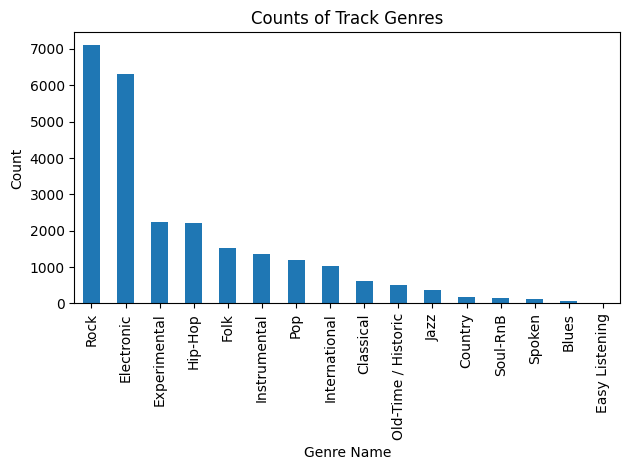

In [103]:
plt.figure()
tracks.parent_genre_title.value_counts().plot(kind='bar')
plt.title('Counts of Track Genres')
plt.xlabel('Genre Name')
plt.ylabel('Count')
plt.tight_layout()
plt.savefig('./visualizations/genres_count.png')

In [102]:
def load_mp3(fpath):
    audio = tfio.audio.AudioIOTensor(fpath)

    return audio

rates = {}
for idx, file in tqdm(enumerate(files)):
    mp3 = load_mp3(file)
    rates[medium_track_ids[idx]] = mp3.rate.numpy()

0it [00:00, ?it/s]

3321it [00:24, 133.38it/s]


KeyboardInterrupt: 

In [ ]:
bad_sample_rates = []

for track in rates:
    if rates[track] in [32000, 22050]:
        bad_sample_rates.append(track)

bad_sample_df = tracks[tracks['track_id'].isin(bad_sample_rates)]
bad_sample_df

,track_id,track_genres,parsed_genres,num_genres
10097,16351,"[{'genre_id': '8', 'genre_title': 'Old-Time / ...","[{'genre_id': '8', 'genre_title': 'Old-Time / ...",1
10098,16352,"[{'genre_id': '8', 'genre_title': 'Old-Time / ...","[{'genre_id': '8', 'genre_title': 'Old-Time / ...",1
10099,16353,"[{'genre_id': '8', 'genre_title': 'Old-Time / ...","[{'genre_id': '8', 'genre_title': 'Old-Time / ...",1
10133,16398,"[{'genre_id': '8', 'genre_title': 'Old-Time / ...","[{'genre_id': '8', 'genre_title': 'Old-Time / ...",1
10134,16399,"[{'genre_id': '8', 'genre_title': 'Old-Time / ...","[{'genre_id': '8', 'genre_title': 'Old-Time / ...",1
10135,16400,"[{'genre_id': '8', 'genre_title': 'Old-Time / ...","[{'genre_id': '8', 'genre_title': 'Old-Time / ...",1
10136,16401,"[{'genre_id': '8', 'genre_title': 'Old-Time / ...","[{'genre_id': '8', 'genre_title': 'Old-Time / ...",1
10137,16402,"[{'genre_id': '8', 'genre_title': 'Old-Time / ...","[{'genre_id': '8', 'genre_title': 'Old-Time / ...",1
10138,16403,"[{'genre_id': '8', 'genre_title': 'Old-Time / ...","[{'genre_id': '8', 'genre_title': 'Old-Time / ...",1
10139,16404,"[{'genre_id': '8', 'genre_title': 'Old-Time / ...","[{'genre_id': '8', 'genre_title': 'Old-Time / ...",1


In [ ]:
for i in bad_sample_df['parsed_genres']:
    print(i)

[{'genre_id': '8', 'genre_title': 'Old-Time / Historic', 'genre_url': 'http://freemusicarchive.org/genre/Old-Time__Historic/'}]
[{'genre_id': '8', 'genre_title': 'Old-Time / Historic', 'genre_url': 'http://freemusicarchive.org/genre/Old-Time__Historic/'}]
[{'genre_id': '8', 'genre_title': 'Old-Time / Historic', 'genre_url': 'http://freemusicarchive.org/genre/Old-Time__Historic/'}]
[{'genre_id': '8', 'genre_title': 'Old-Time / Historic', 'genre_url': 'http://freemusicarchive.org/genre/Old-Time__Historic/'}]
[{'genre_id': '8', 'genre_title': 'Old-Time / Historic', 'genre_url': 'http://freemusicarchive.org/genre/Old-Time__Historic/'}]
[{'genre_id': '8', 'genre_title': 'Old-Time / Historic', 'genre_url': 'http://freemusicarchive.org/genre/Old-Time__Historic/'}]
[{'genre_id': '8', 'genre_title': 'Old-Time / Historic', 'genre_url': 'http://freemusicarchive.org/genre/Old-Time__Historic/'}]
[{'genre_id': '8', 'genre_title': 'Old-Time / Historic', 'genre_url': 'http://freemusicarchive.org/genre